### Install PySpark

In [1]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 59kB/s 
     |████████████████████████████████| 204kB 43.6MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=1933ef2fedd8a02daeaef4822c6b5b891d7de4be11a7f7f484722e89d6eb18c7
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


### Create Spark Context

In [2]:
from pyspark import SparkContext
from pyspark.sql import Row
from pyspark.sql import *
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql.functions import col

In [3]:
spark = SparkContext.getOrCreate()

### Load Dataset

In [4]:
spark.addFile('https://raw.githubusercontent.com/JonatasDeOliveira/movie-it/master/data/moviesOnStreamingPlatforms_updated.csv')

In [6]:
sql_context = SQLContext(spark)
movies_df = sql_context.read.csv(SparkFiles.get("moviesOnStreamingPlatforms_updated.csv"), header=True, inferSchema= True)

In [7]:
movies_df.show(20, False)

+---+---+----------------------------------+----+---+----+---------------+-------+----+-----------+-------+----+-------------------------------------------+----------------------------------------+-------------------------------------------+-------------------------------------------+-------+
|_c0|ID |Title                             |Year|Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Type|Directors                                  |Genres                                  |Country                                    |Language                                   |Runtime|
+---+---+----------------------------------+----+---+----+---------------+-------+----+-----------+-------+----+-------------------------------------------+----------------------------------------+-------------------------------------------+-------------------------------------------+-------+
|0  |1  |Inception                         |2010|13+|8.8 |87%            |1      |0   |0          |0      |0   |Christ

In [8]:
movies_df.toPandas().isna().sum()

_c0                    0
ID                     0
Title                  0
Year                   0
Age                 9389
IMDb                 571
Rotten Tomatoes    11586
Netflix                1
Hulu                   0
Prime Video            0
Disney+                0
Type                   0
Directors            725
Genres               275
Country              435
Language             599
Runtime              592
dtype: int64

### Pre Processing Dataset 

In [9]:
movies_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Type: integer (nullable = true)
 |-- Directors: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Language: string (nullable = true)
 |-- Runtime: integer (nullable = true)



Pontos notados:

- Primeiramente, percebemos que temos duas colunas com "ids". Como pegamos esses dados do kaggle possivelmente esta primeira coluna não é necessária.
- Há uma coluna Type que possui somente valores iguais a 0. Procuramos entender o que seria mas não encontramos, vamos dropar essa coluna.
- Outra observação é que as colunas Directors, Genres, Country e Language são listas e estão como strings devemos processar também as mesmas.
- Colunas Age e Year estão como string, devem ser transformadas para integer.

In [10]:
from pyspark.sql.functions import split

In [11]:
movies_df_drop_c0 = movies_df.drop('_c0')

In [12]:
movies_df_drop_type = movies_df_drop_c0.drop('Type')

In [13]:
movies_df_split = (movies_df_drop_type.withColumn('DirectorsArray', split('Directors', ','))
.withColumn('GenresArray', split('Genres', ','))
.withColumn('CountriesArray', split('Country', ','))
.withColumn('LanguagesArray', split('Language', ','))
.drop('Directors')
.drop('Genres')
.drop('Country')
.drop('Language'))

In [14]:
# checando se todas as idades seguem o regex [0-9]+\+
df_filtered_age_pattern = movies_df_split.filter(col('Age').rlike('[0-9]+\+'))
df_filtered_age_pattern.count() == movies_df_split.count()

False

In [15]:
# verificar idades que não seguem o padrão
df_filtered_not_age_pattern = movies_df_split.filter(~col('Age').rlike('[0-9]+\+'))
df_filtered_not_age_pattern.show(5, False)

+---+-----------------------------------+----+---+----+---------------+-------+----+-----------+-------+-------+---------------------------+-----------------------------------------------------------------+----------------------------------------------------+----------------------------------+
|ID |Title                              |Year|Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray             |GenresArray                                                      |CountriesArray                                      |LanguagesArray                    |
+---+-----------------------------------+----+---+----+---------------+-------+----+-----------+-------+-------+---------------------------+-----------------------------------------------------------------+----------------------------------------------------+----------------------------------+
|55 |Willy Wonka & the Chocolate Factory|1971|all|7.8 |91%            |1      |0   |0          |0      |100    |[Me

In [16]:
# verficar que o padrão de idade em regex [0-9]+\+ unido a o padrão com 'all' contemplam todo o dataframe
df_filtered_pattern_all = movies_df_split.filter(col('Age').rlike('[0-9]+\+') | (col('Age') == 'all'))
movies_df_split.count() == df_filtered_pattern_all.count()

False

In [17]:
df_filtered_not_pattern_all = movies_df_split.filter(~(col('Age').rlike('[0-9]+\+') | (col('Age') == 'all')))
df_filtered_not_pattern_all.show(5, False)

+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+
|ID   |Title                        |Year                     |Age |IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|DirectorsArray|GenresArray|CountriesArray|LanguagesArray|
+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+
|15902|"""22"" A film about Veterans| Healthcare and Suicide."|2018|null|null           |null   |0   |0          |1      |null   |[0]           |null       |null          |null          |
+-----+-----------------------------+-------------------------+----+----+---------------+-------+----+-----------+-------+-------+--------------+-----------+--------------+--------------+



Claramente a linha apresentada acima é um erro pois a idade está como um ano, o ano está como um texto e a maioria das outras colunas estão vazias, vamos remover essa linha.

In [18]:
movies_df_filtered_age = movies_df_split.where(col('ID') != 15902)

Agora vamos processar Age para aparecer como um inteiro em todo dataframe. A idade (Age) possui dois formatos, a idade mínima pra assistir o filme acompanhada de um caracter '+' ou o texto escrito 'all'. Iremos seguir os seguintes passos:
- remover o caracter '+' das idades mínimas;
- tranformar todas linha com o valor 'all' para 0;
- transformar para um inteiro renomeando a coluna para MinimumAge;

In [19]:
movies_df_filtered_age.where(col('Age').isNull()).show()

+---+--------------------+----+----+----+---------------+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+
| ID|               Title|Year| Age|IMDb|Rotten Tomatoes|Netflix|Hulu|Prime Video|Disney+|Runtime|      DirectorsArray|         GenresArray|      CountriesArray|      LanguagesArray|
+---+--------------------+----+----+----+---------------+-------+----+-----------+-------+-------+--------------------+--------------------+--------------------+--------------------+
| 33|      Train to Busan|2016|null| 7.5|            94%|      1|   0|          1|      0|    118|      [Sang-ho Yeon]|[Action, Horror, ...|       [South Korea]|  [Korean, Hawaiian]|
| 58|      A Silent Voice|2016|null| 8.2|            94%|      1|   0|          0|      0|    130|      [Naoko Yamada]|[Animation, Drama...|             [Japan]|[Japanese, Japane...|
| 90|       The Dawn Wall|2018|null| 8.1|           100%|      1|   0|          0|   

In [20]:
from pyspark.sql.functions import translate
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import udf

def transform_all_age_value(age):
  if age == 'all':
    return 0
  if age is None:
    return -1
  return int(age)

transformAllAgeValue = udf(lambda x: transform_all_age_value(x), IntegerType())

movies_df_age_processed = movies_df_filtered_age.withColumn("Age", translate('Age', '+', ''))
movies_df_classification = movies_df_age_processed.withColumn("MinimumClassification", transformAllAgeValue(col('Age'))).drop('Age')

Note que existe idade indicativa nula, setamos esses valores como -1.

In [21]:
movies_df_classification.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)



Analisando o schema novamente, podemos ver que assim como o campo Age, o campo Year deveria estar como Integer, vamos arrumar isso.

In [22]:
movies_df_year_processed = movies_df_classification.withColumn("Year", col("Year").cast(IntegerType()))

In [23]:
movies_df_year_processed.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Rotten Tomatoes: string (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)



Agora precisamos modificar a coluna Rotten Tomatoes para ser um integer.

In [24]:
movies_df_rotten_char = movies_df_year_processed.withColumn("RottenTomatoes", translate('Rotten Tomatoes', '%', '')).drop('Rotten Tomatoes')
movies_df_rotten_int = movies_df_rotten_char.withColumn("RottenTomatoes", col("RottenTomatoes").cast(IntegerType()))
movies_df_padronized_rotten = movies_df_rotten_int.withColumn("RottenTomatoes", col("RottenTomatoes") / 10)

In [25]:
movies_df_padronized_rotten.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- IMDb: double (nullable = true)
 |-- Netflix: integer (nullable = true)
 |-- Hulu: integer (nullable = true)
 |-- Prime Video: integer (nullable = true)
 |-- Disney+: integer (nullable = true)
 |-- Runtime: integer (nullable = true)
 |-- DirectorsArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- GenresArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- CountriesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- LanguagesArray: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- MinimumClassification: integer (nullable = true)
 |-- RottenTomatoes: double (nullable = true)



In [26]:
movies_df_processed = movies_df_padronized_rotten

In [27]:
from pyspark.sql.functions import explode

movie_director_df = movies_df_processed.select('ID', 'DirectorsArray').withColumn('Director', explode(col('DirectorsArray'))).select('ID', 'Director')
movie_genre_df = movies_df_processed.select('ID', 'GenresArray').withColumn('Genre', explode(col('GenresArray'))).select('ID', 'Genre')
movie_country_df = movies_df_processed.select('ID', 'CountriesArray').withColumn('Country', explode(col('CountriesArray'))).select('ID', 'Country')
movie_language_df = movies_df_processed.select('ID', 'LanguagesArray').withColumn('Language', explode(col('LanguagesArray'))).select('ID', 'Language')

### Removing Outliers 

In [28]:
movies_df_pd = movies_df_processed.toPandas()

In [29]:
movies_df_pd.describe()

,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes
count,16743.000000,16743.000000,16173.000000,16743.000000,16743.000000,16743.000000,16743.000000,16152.000000,16743.000000,5158.000000
mean,8372.050290,2003.013140,5.902751,0.212626,0.053933,0.737801,0.033686,93.413447,5.065520,6.542846
std,4833.514844,20.674614,1.347867,0.409178,0.225892,0.439843,0.180424,28.219222,7.998182,2.661450
min,1.000000,1902.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.200000
25%,4186.500000,2000.000000,5.100000,0.000000,0.000000,0.000000,0.000000,82.000000,-1.000000,4.400000
50%,8372.000000,2012.000000,6.100000,0.000000,0.000000,1.000000,0.000000,92.000000,-1.000000,7.100000
75%,12557.500000,2016.000000,6.900000,0.000000,0.000000,1.000000,0.000000,104.000000,13.000000,8.800000
max,16744.000000,2020.000000,9.300000,1.000000,1.000000,1.000000,1.000000,1256.000000,18.000000,10.000000


#### Univariado

Percebemos que as métricas do runtime estão um pouco estranhas o mínimo e o máximo estão muito distantes dos valores dos quartis, isso pode indicar que existem outliers. Analisando os quartis as durações dos filmes possuem valores esperados devido ao nosso conhecimento do problema (filmes), porém os mínimos e máximo tem valores muito díspares, o que indica que há outliers no dataset.

Vamos visualizar o runtime em forma de gráfico.

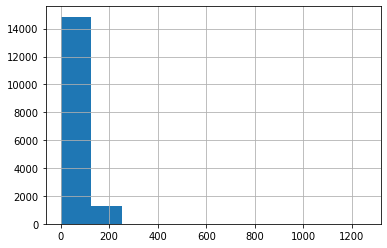

In [30]:
movies_df_pd['Runtime'].hist()

A distribuição de runtime dos filmes ficou ruim de ser visualizada no histograma possivelmente por causa de outliers. Iremos utiliza o log10 para visualizar melhor.

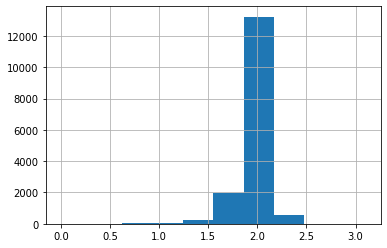

In [31]:
from numpy import log10
movies_df_pd['runtime_log'] = log10(movies_df_pd['Runtime'])
movies_df_pd['runtime_log'].hist()

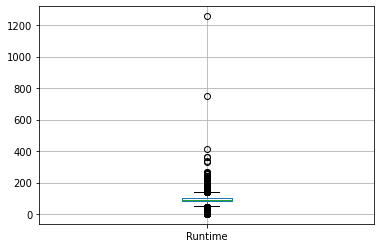

In [32]:
movies_df_pd.boxplot(column='Runtime')

Analisando o boxplot, fica claro que existem outliers. Vamos Fazer o processo de remoção utilizando o Z-Score Robusto (MAD). 

In [33]:
from numpy import abs
mad = abs(movies_df_pd['runtime_log'] - movies_df_pd['runtime_log'].median()).median()*(1/0.6745)
print(mad)

0.07409040023993868


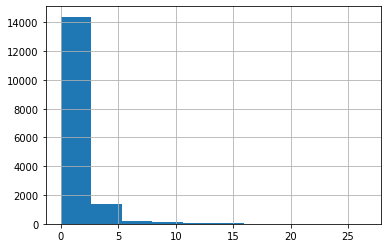

In [34]:
(abs(movies_df_pd['runtime_log']-movies_df_pd['runtime_log'].median())/mad).hist()

In [35]:
movies_df_mad = movies_df_pd[abs(movies_df_pd['runtime_log']-movies_df_pd['runtime_log'].median())/mad < 6]
movies_df_mad

,ID,Title,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,DirectorsArray,GenresArray,CountriesArray,LanguagesArray,MinimumClassification,RottenTomatoes,runtime_log
0,1,Inception,2010,8.8,1,0,0,0,148.0,[Christopher Nolan],"[Action, Adventure, Sci-Fi, Thriller]","[United States, United Kingdom]","[English, Japanese, French]",13,8.7,2.170262
1,2,The Matrix,1999,8.7,1,0,0,0,136.0,"[Lana Wachowski, Lilly Wachowski]","[Action, Sci-Fi]",[United States],[English],18,8.7,2.133539
2,3,Avengers: Infinity War,2018,8.5,1,0,0,0,149.0,"[Anthony Russo, Joe Russo]","[Action, Adventure, Sci-Fi]",[United States],[English],13,8.4,2.173186
3,4,Back to the Future,1985,8.5,1,0,0,0,116.0,[Robert Zemeckis],"[Adventure, Comedy, Sci-Fi]",[United States],[English],7,9.6,2.064458
4,5,"The Good, the Bad and the Ugly",1966,8.8,1,0,1,0,161.0,[Sergio Leone],[Western],"[Italy, Spain, West Germany]",[Italian],18,9.7,2.206826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16733,16735,Sultan And The Rock Star,1980,5.9,0,0,0,1,60.0,[Edward M. Abroms],"[Adventure, Drama, Family]",[United States],[English],-1,NaN,1.778151
16736,16738,The Bears and I,1974,6.2,0,0,0,1,89.0,[Bernard McEveety],"[Drama, Family]",[United States],[English],0,NaN,1.949390
16737,16739,Whispers: An Elephant's Tale,2000,5.0,0,0,0,1,72.0,[Dereck Joubert],"[Adventure, Family]",[United States],[English],0,NaN,1.857332
16738,16740,The Ghosts of Buxley Hall,1980,6.2,0,0,0,1,120.0,[Bruce Bilson],"[Comedy, Family, Fantasy, Horror]",[United States],[English],-1,NaN,2.079181


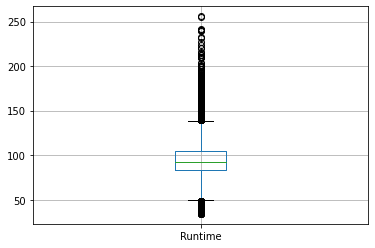

In [36]:
movies_df_mad.boxplot(column='Runtime')

In [37]:
movies_no_outliers = movies_df_mad

#### Bivariado

Vamos detectar outliers agora a partir das colunas de notas, IMDb e Rotten Tomatoes.

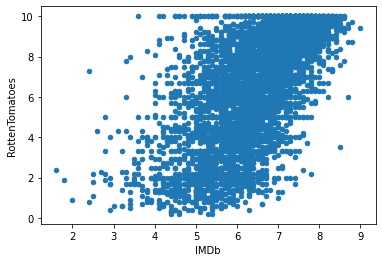

In [72]:
movies_df_pd.plot.scatter(x='IMDb', y='RottenTomatoes')

In [79]:
movies_df_pd['rating_rate'] = movies_df_pd['RottenTomatoes'] / movies_df_pd['IMDb']
movies_df_pd['rating_rate'].describe()

count    5156.000000
mean        1.009732
std         0.373968
min         0.037037
25%         0.759815
50%         1.095564
75%         1.274395
max         3.041667
Name: rating_rate, dtype: float64

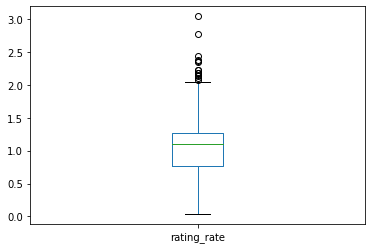

In [80]:
movies_df_pd['rating_rate'].plot.box()

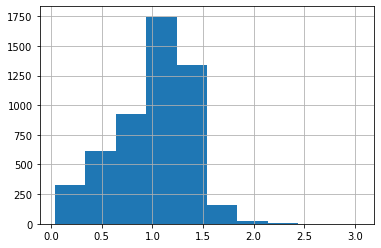

In [81]:
movies_df_pd['rating_rate'].hist()

In [83]:
mad = abs(movies_df_pd['rating_rate'] - movies_df_pd['rating_rate'].median()).median()*(1/0.6745)
print(mad)

0.33925697380108055


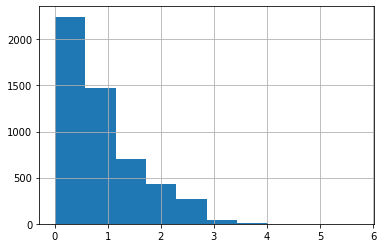

In [84]:
(abs(movies_df_pd['rating_rate']-movies_df_pd['rating_rate'].median())/mad).hist()

In [114]:
movies_df_pd[abs(movies_df_pd['rating_rate']-movies_df_pd['rating_rate'].median())/mad >= 3][['IMDb', 'RottenTomatoes', 'rating_rate']]

,IMDb,RottenTomatoes,rating_rate
1368,4.7,10.0,2.127660
2043,4.4,0.3,0.068182
4208,4.4,0.2,0.045455
4257,5.4,0.2,0.037037
5342,4.6,10.0,2.173913
5466,4.1,8.8,2.146341
5563,4.5,10.0,2.222222
5888,4.2,10.0,2.380952
6041,4.6,10.0,2.173913
6158,4.1,10.0,2.439024


In [115]:
movies_df_mad_bi = movies_df_pd[abs(movies_df_pd['rating_rate']-movies_df_pd['rating_rate'].median())/mad < 3]

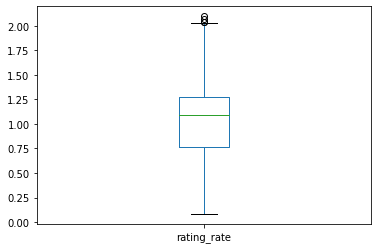

In [116]:
movies_df_mad_bi['rating_rate'].plot.box()

### Análises Descritivas

Iremos rodar a correlação de spearman sobre o dataset para verificar se há algum tipo de correlação entre as colunas.

Podemos perceber que há uma correlação alta e positiva entre as colunas RottenTomatoes e IMDb, que é esperado porque ambos representam a opinião sobre o filme.

In [113]:
movies_no_outliers.corr(method='spearman')

,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes,runtime_log,rating_diff,rating_rate
ID,1.000000,-0.333977,-0.290945,-0.775652,-0.217908,0.540638,0.396864,-0.194860,-0.139791,-0.280900,-0.194860,-0.194904,-0.194904
Year,-0.333977,1.000000,-0.119598,0.322964,0.155237,-0.282387,-0.185283,0.022161,-0.038165,0.078673,0.022161,0.159531,0.159531
IMDb,-0.290945,-0.119598,1.000000,0.032704,-0.012826,-0.051463,0.038031,0.202972,-0.096270,0.628948,0.202972,0.284984,0.284984
Netflix,-0.775652,0.322964,0.032704,1.000000,-0.213105,-0.645898,-0.152230,0.103137,0.096332,0.021939,0.103137,-0.002564,-0.002564
Hulu,-0.217908,0.155237,-0.012826,-0.213105,1.000000,-0.243753,-0.086503,0.018298,0.045988,0.020820,0.018298,0.034433,0.034433
Prime Video,0.540638,-0.282387,-0.051463,-0.645898,-0.243753,1.000000,-0.309355,-0.060340,-0.039899,-0.049000,-0.060340,-0.023535,-0.023535
Disney+,0.396864,-0.185283,0.038031,-0.152230,-0.086503,-0.309355,1.000000,-0.028281,-0.071690,-0.015349,-0.028281,-0.046064,-0.046064
Runtime,-0.194860,0.022161,0.202972,0.103137,0.018298,-0.060340,-0.028281,1.000000,0.161117,-0.010858,1.000000,-0.107675,-0.107675
MinimumClassification,-0.139791,-0.038165,-0.096270,0.096332,0.045988,-0.039899,-0.071690,0.161117,1.000000,-0.211772,0.161117,-0.216616,-0.216616
RottenTomatoes,-0.280900,0.078673,0.628948,0.021939,0.020820,-0.049000,-0.015349,-0.010858,-0.211772,1.000000,-0.010858,0.896927,0.896927


Agora ao analisar a quantidade de filmes por plataforma de streaming, percebemos que a maior parte dos dados é composta por filmes que estão no Prime Video.

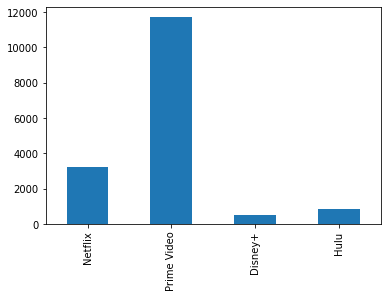

In [39]:
movies_no_outliers[['Netflix', 'Prime Video', 'Disney+', 'Hulu']].sum(skipna=True).plot.bar()

Agora vamos analisar a criação de filmes ao longo das décadas.

In [105]:
movies_no_outliers['decade'] = movies_no_outliers['Year'].floordiv(10) * 10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


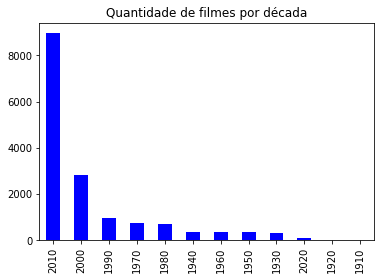

In [41]:
quantity_movies_by_sec = movies_no_outliers['decade'].value_counts()
quantity_movies_by_sec.plot.bar(color=(0,0,1), title='Quantidade de filmes por década')

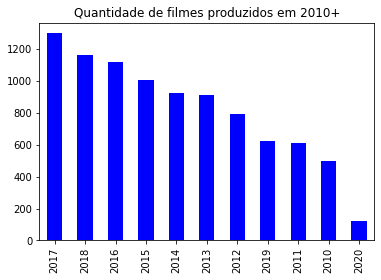

In [42]:
movies_df_2010 = movies_no_outliers[movies_no_outliers['Year'] >= 2010]
movies_df_2010 = movies_df_2010.sort_values(['Year'])
quantity_movies_2010 = movies_df_2010['Year'].value_counts()
quantity_movies_2010.plot.bar(color=(0,0,1), title='Quantidade de filmes produzidos em 2010+')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


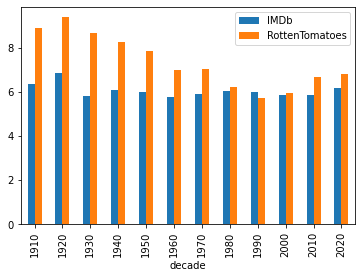

In [43]:
t = movies_df_mad.groupby('decade')['IMDb', 'RottenTomatoes'].mean()
t.plot.bar()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


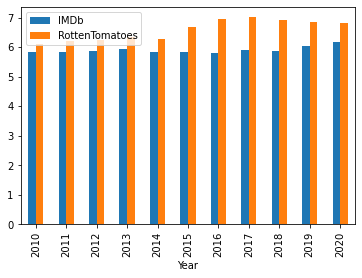

In [44]:
t = movies_df_2010.groupby('Year')['IMDb', 'RottenTomatoes'].mean()
t.plot.bar()

In [45]:
from pyspark.sql.functions import when,count,countDistinct

movies_df_aval = movies_df_processed.where(col('IMDb').isNotNull() & col('RottenTomatoes').isNotNull())

movies_df_aval.agg(
    count(when(col("IMDb") >= 9, True)).alias('IMDb Count'),
    count(when(col("RottenTomatoes") >= 9, True)).alias('RottenTomatoes Count')
).show()

+----------+--------------------+
|IMDb Count|RottenTomatoes Count|
+----------+--------------------+
|         1|                1126|
+----------+--------------------+



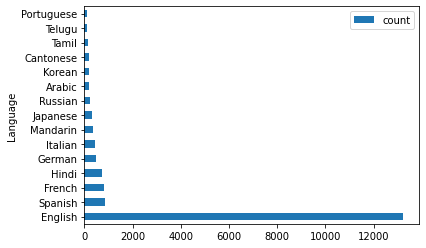

In [46]:
movies_count_by_language = movie_language_df.groupBy('Language').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_language.nlargest(15, 'count').plot.barh(x='Language')

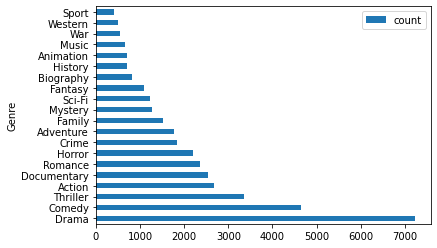

In [47]:
movies_count_by_genre = movie_genre_df.groupBy('Genre').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_genre.nlargest(20, 'count').plot.barh(x='Genre')

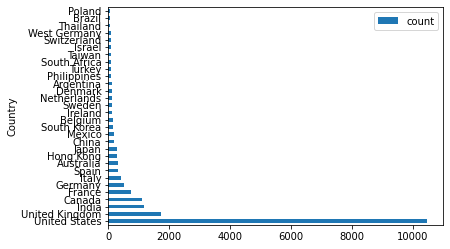

In [48]:
movies_count_by_country = movie_country_df.groupBy('Country').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_country.nlargest(30, 'count').plot.barh(x='Country')

#### Análise Diretores





Inicialmente, vamos ver os top 20 diretores que fizeram mais filmes

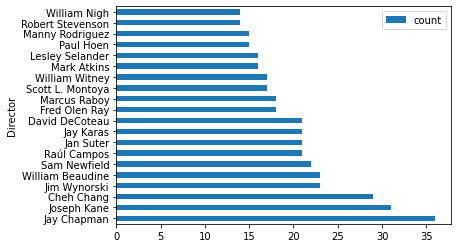

In [49]:
movies_count_by_directors = movie_director_df.groupBy('Director').agg(countDistinct('ID').alias('count')).toPandas()
movies_count_by_directors.nlargest(20, 'count').plot.barh(x='Director')

In [50]:
from pyspark.sql.functions import mean

directors_stats_pyspark = movie_director_df.distinct()\
                            .join(movies_df_processed, movies_df_processed['ID'] == movie_director_df['ID'])\
                            .select('Director', 'IMDb', 'RottenTomatoes', movie_director_df['ID'])\
                            .groupBy('Director')\
                            .agg(count('ID').alias('movies_count'), mean('IMDb').alias('IMDb_mean'), mean('RottenTomatoes').alias('RottenTomatoes_mean'))\
                            
directors_stats = directors_stats_pyspark.toPandas()
directors_stats

,Director,movies_count,IMDb_mean,RottenTomatoes_mean
0,Rhiannon Bannenberg,1,5.5,NaN
1,Perry Moore,1,5.9,1.2
2,John Wells,1,6.7,6.7
3,Todd E. Freeman,1,3.7,NaN
4,Doug Walker,1,3.5,1.9
...,...,...,...,...
12448,Roozbeh Kaboly,1,3.3,NaN
12449,Satoshi Nishimura,1,7.5,NaN
12450,Eric Forsberg,1,2.4,0.8
12451,Charles A. Addessi,1,5.7,1.9


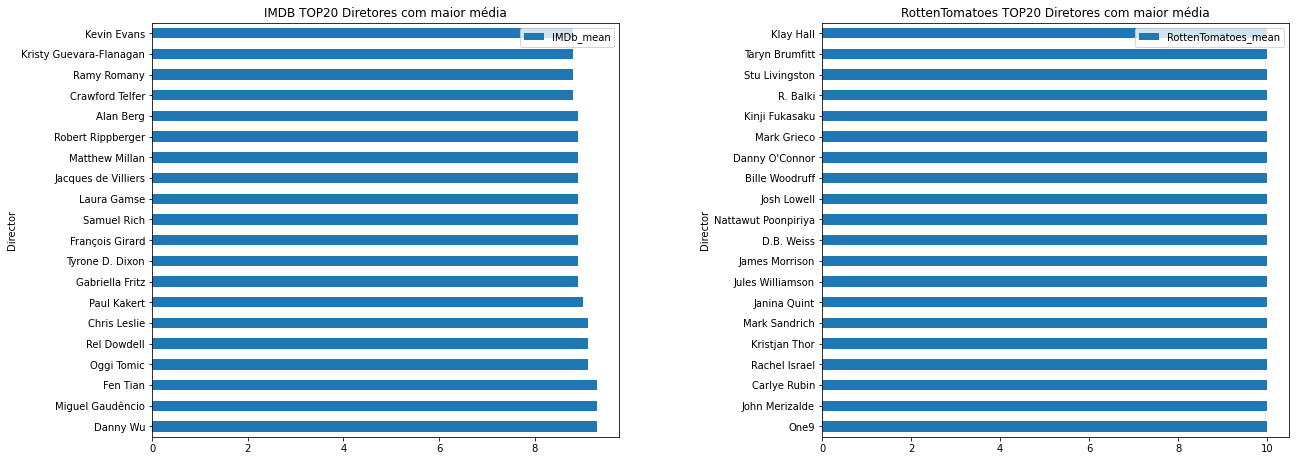

In [51]:
import matplotlib.pyplot as plt

sorted_imdb = directors_stats.sort_values(by='IMDb_mean', ascending=False).head(20) 
sorted_rotten = directors_stats.sort_values(by='RottenTomatoes_mean', ascending=False).head(20) 

fig, axes = plt.subplots(1, 2)
fig.tight_layout(pad=3.0)
sorted_imdb[['Director', 'IMDb_mean']].plot.barh(x='Director', ax=axes[0], figsize=(20, 8), title='IMDB TOP20 Diretores com maior média')
sorted_rotten[['Director', 'RottenTomatoes_mean']].plot.barh(x='Director', ax=axes[1], figsize=(20, 8), title='RottenTomatoes TOP20 Diretores com maior média')

Esses diretores estão com uma média muito alta, principalmente os do Rotten Tomatoes, no qual todos os Top 20 possuem média 10. Analisando o Danny Wu, por exemplo, podemos notar que só existe uma nota relacionada a ele

In [52]:
movie_director_df.distinct()\
.join(movies_df_processed, movies_df_processed['ID'] == movie_director_df['ID'])\
.select('Director', 'IMDb').where(col('Director') == 'Danny Wu').show()

+--------+----+
|Director|IMDb|
+--------+----+
|Danny Wu| 9.3|
+--------+----+



Vamos ver a quantidade de diretores por filmes feitos:

In [53]:
directors_movie_count = movie_director_df.distinct()\
                            .groupBy('Director')\
                            .agg(count('ID').alias('Total Movies'))\
                            .groupBy('Total Movies').agg(count('Director').alias('Total Director')).orderBy(col('Total Movies')).toPandas()
directors_movie_count

,Total Movies,Total Director
0,1,9549
1,2,1741
2,3,563
3,4,274
4,5,127
5,6,74
6,7,48
7,8,20
8,9,15
9,10,6


Com isso iremos pegar a média de filmes feitos por diretor e fazer nossas analises baseado nos diretores que fizeram pelo menos a media de filmes.

In [54]:
directors_movies_mean = movie_director_df.distinct()\
                            .groupBy('Director')\
                            .agg(count('ID').alias('Total Movies'))\
                            .select(mean('Total Movies').alias('mean'))\
                            .collect()[0][0]
directors_movies_mean

1.4602906930057014

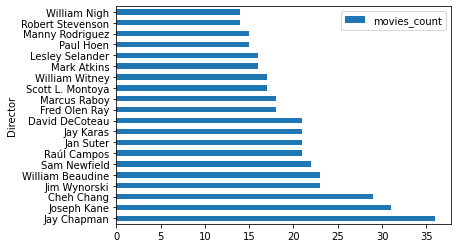

In [55]:
directors_filtered = directors_stats_pyspark.distinct()\
                            .where(col('movies_count') >= directors_movies_mean)\
                            .toPandas()
directors_filtered.nlargest(20, 'movies_count')[['Director', 'movies_count']].plot.barh(x='Director')

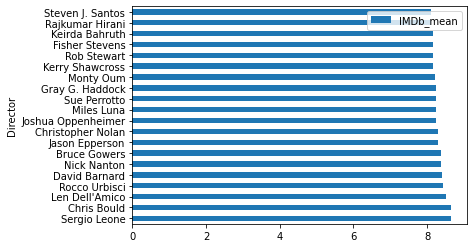

In [56]:
directors_high_grade_count = directors_stats_pyspark.distinct()\
                            .where(col('movies_count') >= directors_movies_mean).toPandas()
directors_high_grade_count.nlargest(20, 'IMDb_mean')[['Director', 'IMDb_mean']].plot.barh(x='Director')

In [57]:
movies_no_outliers.describe()

,ID,Year,IMDb,Netflix,Hulu,Prime Video,Disney+,Runtime,MinimumClassification,RottenTomatoes,runtime_log,decade
count,15764.000000,15764.000000,15466.000000,15764.000000,15764.000000,15764.000000,15764.000000,15764.000000,15764.000000,5072.000000,15764.000000,15764.000000
mean,8321.366278,2002.813055,5.894168,0.206293,0.055379,0.743466,0.033748,94.925400,5.302081,6.535864,1.964522,1997.798148
std,4793.571669,20.670629,1.349739,0.404656,0.228726,0.436734,0.180585,23.321817,8.066751,2.662999,0.106762,20.446816
min,1.000000,1912.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,-1.000000,0.200000,1.531479,1910.000000
25%,4266.750000,2000.000000,5.100000,0.000000,0.000000,0.000000,0.000000,83.000000,-1.000000,4.400000,1.919078,2000.000000
50%,8325.500000,2012.000000,6.100000,0.000000,0.000000,1.000000,0.000000,92.000000,-1.000000,7.100000,1.963788,2010.000000
75%,12445.250000,2016.000000,6.900000,0.000000,0.000000,1.000000,0.000000,105.000000,13.000000,8.800000,2.021189,2010.000000
max,16741.000000,2020.000000,9.300000,1.000000,1.000000,1.000000,1.000000,256.000000,18.000000,10.000000,2.408240,2020.000000


ANALISES
- Qual é mais critico em relacão as notas (imdb ou rotten)
- Quantidade de filmes presentes em cada plataforma
- Alguma relacao de ano + nota / nota + regiao produzida / nota + ator conhecido
- Agrupar por ator para ver qual ator fez mais filme, fazer uma analise do ator + media dos filmes que ele esteve presente
- Existe maior quantidade de filmes em ingles
- Existe maior quantidade de filmes feito nos USA


### Hipóteses

HIPOTESES
1. Notas dos filmes do Imdb e Rotten Tomatoes seguem uma distribuição normal ou a mesma distribuição
2. Filmes de terror e ação tem uma classificacao indicativa maior
3. Filmes de drama tem maior nota no rotten tomatoes
4. Filmes na Plataforma da Netflix possuem notas mais altas

#### Hipótese 1

In [58]:
from scipy import stats

In [59]:
# vamos dropar os nan porque não nos interessa nos cálculos
movies_processed_pd = movies_df_processed.toPandas().dropna()

Vamos checar agora se a diferença entre notas imdb e rotten tomatoes segue uma distribuição normal

In [60]:
movies_processed_pd['grade_difference'] = movies_processed_pd['RottenTomatoes'] - movies_processed_pd['IMDb']

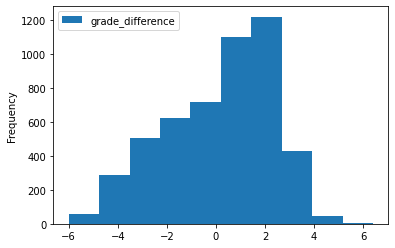

In [61]:
movies_processed_pd[['grade_difference']].plot(kind='hist')

Utilizando a função shapiro percebemos que o p value deu muito baixo rejeitando assim a hipótese nula de que a distribuição é normal. Devemos portanto realizar testes não paramétricos.

In [62]:
stats.shapiro(movies_processed_pd['grade_difference'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9654566645622253, 5.233825781556863e-33)

Apesar de acreditarmos que as notas do IMDb e do Rotten tomatoes seguissem a mesma distribuição indicando que as notas seguem um padrão (divergindo somente na rigidez ou criticidade da nota), o resultado rodando o algoritmo de wilcoxon mostra que as duas notas não seguem a mesma distribuição, como podemos notar com o p-value muito baixo.

In [63]:
stats.wilcoxon(movies_processed_pd['RottenTomatoes'], movies_processed_pd['IMDb'])

WilcoxonResult(statistic=5415767.5, pvalue=1.0323800900489713e-11)

#### Hipótese 2

Vamos agora verificar as idades classificativas de acordo com os gêneros dos filmes, queremos mostrar que filmes de terror e ação são mais propensos a ter classificações mais altas.

In [64]:
# primeiro vamos cruzar os dados de gênero com os de filme
movies_genre_by_minimum_class = movie_genre_df.join(movies_df_processed, movies_df_processed['ID'] == movie_genre_df['ID'])\
                                              .select('Genre', 'MinimumClassification')\
                                              .where(col('MinimumClassification') >= 0)
movies_genre_by_minimum_class_pd = movies_genre_by_minimum_class.toPandas()
movies_genre_by_minimum_class_pd

,Genre,MinimumClassification
0,Action,13
1,Adventure,13
2,Sci-Fi,13
3,Thriller,13
4,Action,18
...,...,...
19211,Adventure,0
19212,Family,0
19213,Comedy,7
19214,Family,7


In [65]:
genres = movies_genre_by_minimum_class_pd.Genre.unique()

In [66]:
movies_genre_by_minimum_class_pd.dtypes

Genre                    object
MinimumClassification     int32
dtype: object

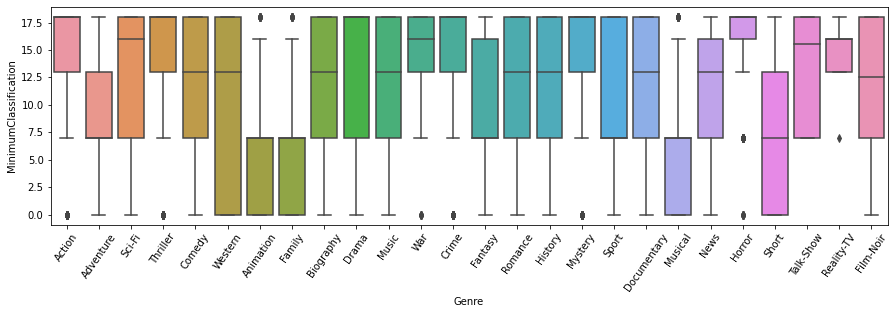

In [67]:
import seaborn as sns
fig, axes = plt.subplots(figsize=(15, 4))
for tick in axes.get_xticklabels():
    tick.set_rotation(55)
sns.boxplot(x='Genre', y='MinimumClassification', data=movies_genre_by_minimum_class_pd, ax=axes)

Como podemos ver através do gráfico acima, genêros como: Ação (Action), Suspense (Thriller), War (Guerra), Crime (Crime), Mistério (Mystery) e Terror (Horror), são genêros que possuem uma variação de classificação bem alta, com foco em Ação, Gerra, Crime que tem o primeiro quartil em 13 anos e o terceiro em 18, com a mediana em 18 anos nos casos de Ação e Crime. Destaca-se o gênero de terror que possui o primeiro quartil em 16 anos e com mediana e terceiro quartil em 18 anos. Os dados mostraram o que já era esperado.

#### Hipótese 3

In [146]:
movies_without_missing_rating = movies_df_processed.where(col('IMDb').isNotNull() & col('RottenTomatoes').isNotNull())\
                                                   .join(movie_genre_df, movies_df_processed['ID'] == movie_genre_df['ID'])\
                                                   .withColumn('rating', (col('IMDb')+col('RottenTomatoes'))/2)\
                                                   .select(movies_df_processed['ID'], col('Genre'), col('IMDb'), col('RottenTomatoes'), col('rating'))\
                                                   .groupBy('Genre')\
                                                   .agg(count('ID').alias('total'), mean('IMDb').alias('IMDb_mean'),mean('RottenTomatoes').alias('RottenTomatoes_mean'), mean('rating').alias('rating_mean'))\
                                                   .toPandas()

Vamos remover gêneros com pouca quantidade de filmes para analisar melhor a relação entre gênero de filmes e notas.

In [147]:
movies_without_missing_rating[['Genre','total']]

,Genre,total
0,Crime,684
1,Romance,905
2,Thriller,1213
3,Adventure,646
4,Drama,2781
5,War,194
6,Documentary,733
7,Reality-TV,3
8,Family,519
9,Fantasy,463


In [148]:
q2 = movies_without_missing_rating['total'].quantile(q=0.25)
q2

119.5

Queremos remover os gêneros com a quantidade de filmes menor que o 

In [149]:
movies_without_missing_rating_out = movies_without_missing_rating[movies_without_missing_rating['total'] >= q2]

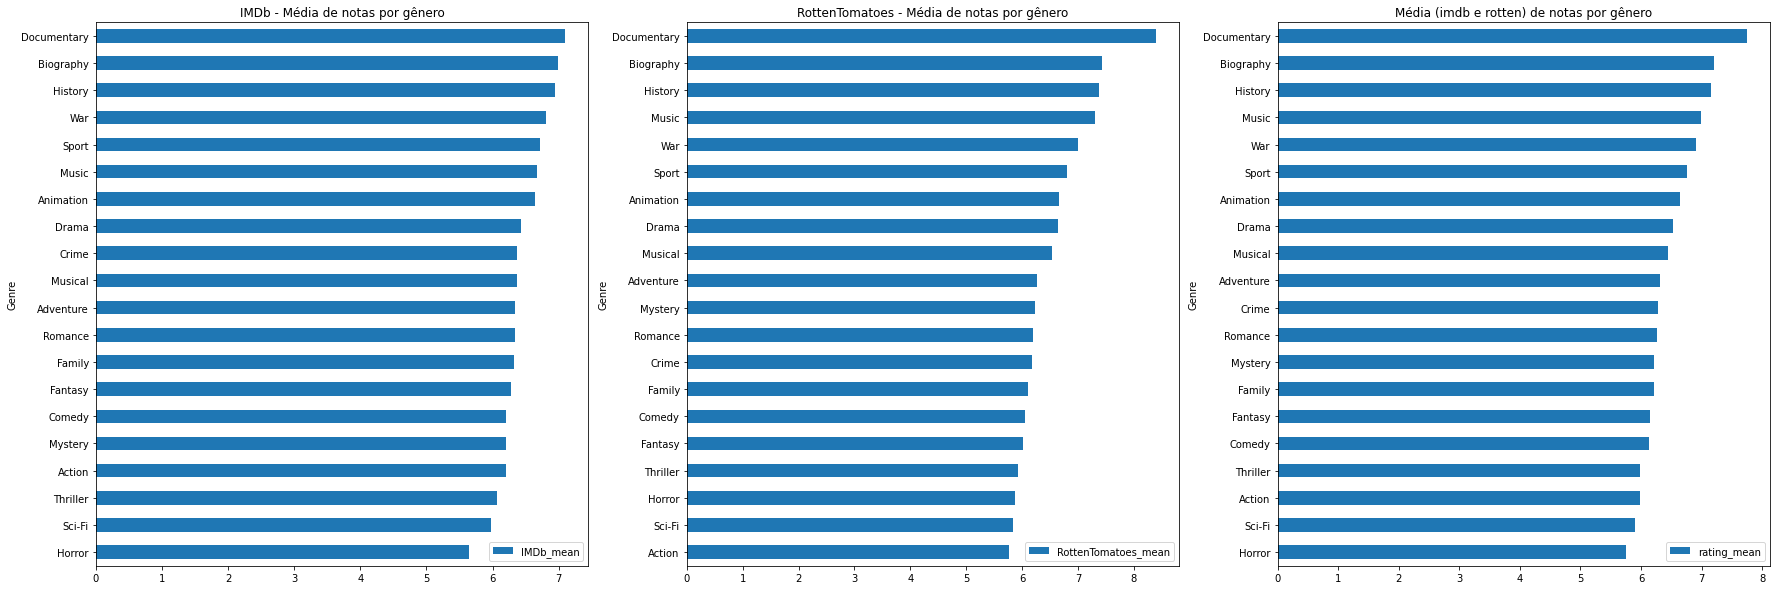

In [150]:
sorted_genre_imdb = movies_without_missing_rating_out.sort_values(by='IMDb_mean', ascending=True)
sorted_genre_rotten = movies_without_missing_rating_out.sort_values(by='RottenTomatoes_mean', ascending=True)
sorted_genre_rating_mean = movies_without_missing_rating_out.sort_values(by='rating_mean', ascending=True)

fig, axes = plt.subplots(1, 3)

sorted_genre_imdb[['Genre', 'IMDb_mean']].plot.barh(x='Genre', ax=axes[0], figsize=(30, 10), title='IMDb - Média de notas por gênero')
sorted_genre_rotten[['Genre', 'RottenTomatoes_mean']].plot.barh(x='Genre', ax=axes[1], figsize=(30, 10), title='RottenTomatoes - Média de notas por gênero')
sorted_genre_rating_mean[['Genre', 'rating_mean']].plot.barh(x='Genre', ax=axes[2], figsize=(30, 10), title='Média (imdb e rotten) de notas por gênero')

Nossa hipótese foi refutada, podemos perceber que filmes relacionados a história/documentário são os mais bem avaliados.

#### Hipótese 4

Text(0.5, 1.0, 'Rotten Tomatoes')

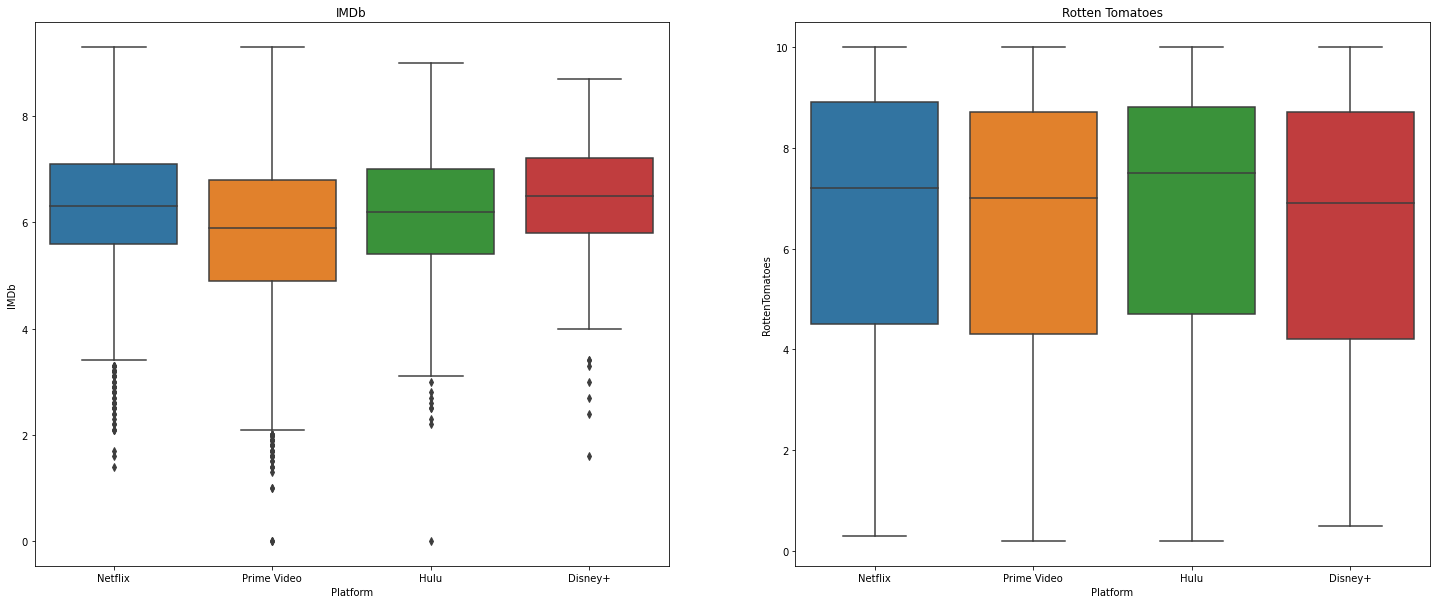

In [117]:
plataform_rating = movies_df_processed.toPandas().melt(id_vars=['IMDb', 'RottenTomatoes'], value_vars=['Netflix', 'Prime Video', 'Hulu', 'Disney+'], var_name='Platform', value_name='Has')
plataform_rating = plataform_rating[plataform_rating['Has'] == 1]
fig, axes = plt.subplots(1,2, figsize=(25, 10))
sns.boxplot(x='Platform', y='IMDb', data=plataform_rating, ax=axes[0]).set_title('IMDb')
sns.boxplot(x='Platform', y='RottenTomatoes', data=plataform_rating, ax=axes[1]).set_title('Rotten Tomatoes')